In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


# konieczny restart kernela po instalacji

In [2]:
# Analiza
import pandas as pd
import numpy as np
import re

# Wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Analiza statystyczna
from scipy import stats
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Modelowanie i trasformacje
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, confusion_matrix, ConfusionMatrixDisplay

# PyCaret
from pycaret.classification import setup, compare_models, add_metric, ClassificationExperiment

# Interpretacja
import shap

In [4]:
import ssl
import urllib
ssl._create_default_https_context = ssl._create_unverified_context

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572) 
  
# data (as pandas dataframes) 
X = taiwanese_bankruptcy_prediction.data.features 
y = taiwanese_bankruptcy_prediction.data.targets 
  
# metadata 
print(taiwanese_bankruptcy_prediction.metadata) 
  
# variable information 
print(taiwanese_bankruptcy_prediction.variables) 

{'uci_id': 572, 'name': 'Taiwanese Bankruptcy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/572/data.csv', 'abstract': 'The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6819, 'num_features': 95, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Bankrupt?'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5004D', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': Non

# 1. EDA

### a. Read and inspect

In [10]:
# combine
dt = pd.concat([y, X], axis=1)

#### Importuj dane

In [14]:
# variable names with space at the begining
dt.columns = dt.columns.str.strip()

# dim
dt.shape

(6819, 96)

#### Identyfikacja braków danych

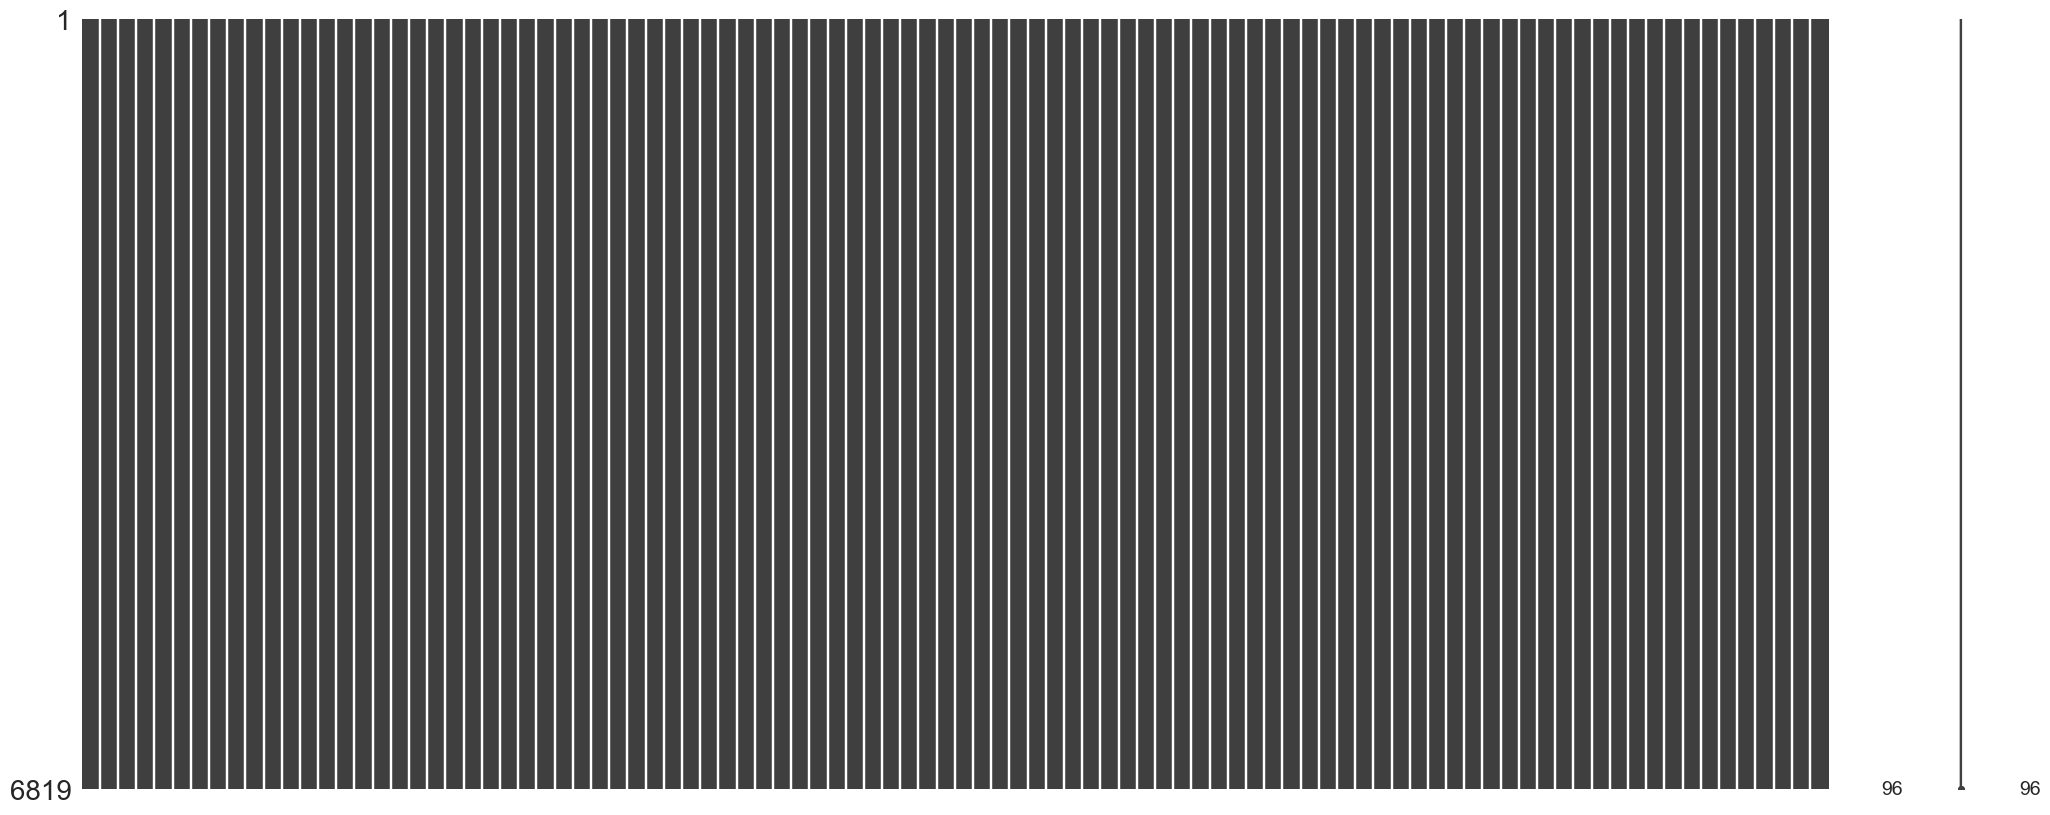

In [15]:
# missing data
msno.matrix(dt)
plt.show()

#### Podstawowe informacje

In [18]:
dt.info() 
# check: Liability-Assets Flag, Net Income Flag

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [19]:
# change display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Disable scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)

dt.describe().T

# Net Income Flag <- to be removed

count           mean  \
Bankrupt?                                          6819.000          0.032   
ROA(C) before interest and depreciation before ... 6819.000          0.505   
ROA(A) before interest and % after tax             6819.000          0.559   
ROA(B) before interest and depreciation after tax  6819.000          0.554   
Operating Gross Margin                             6819.000          0.608   
Realized Sales Gross Margin                        6819.000          0.608   
Operating Profit Rate                              6819.000          0.999   
Pre-tax net Interest Rate                          6819.000          0.797   
After-tax net Interest Rate                        6819.000          0.809   
Non-industry income and expenditure/revenue        6819.000          0.304   
Continuous interest rate (after tax)               6819.000          0.781   
Operating Expense Rate                             6819.000 1995347312.803   
Research and development expense rate              6819.000 1950427306.057   
Cash flow rate                                     6819.000          0.467   
Interest-bearing debt interest rate                6819.000   16448012.906   
Tax rate (A)                                       6819.000          0.115   
Net Value Per Share (B)                            6819.000          0.191   
Net Value Per Share (A)                            6819.000          0.191   
Net Value Per Share (C)                            6819.000          0.191   
Persistent EPS in the Last Four Seasons            6819.000          0.229   
Cash Flow Per Share                                6819.000          0.323   
Revenue Per Share (Yuan ¥)                         6819.000    1328640.602   
Operating Profit Per Share (Yuan ¥)                6819.000          0.109   
Per Share Net profit before tax (Yuan ¥)           6819.000          0.184   
Realized Sales Gross Profit Growth Rate            6819.000          0.022   
Operating Profit Growth Rate                       6819.000          0.848   
After-tax Net Profit Growth Rate                   6819.000          0.689   
Regular Net Profit Growth Rate                     6819.000          0.689   
Continuous Net Profit Growth Rate                  6819.000          0.218   
Total Asset Growth Rate                            6819.000 5508096595.249   
Net Value Growth Rate                              6819.000    1566212.055   
Total Asset Return Growth Rate Ratio               6819.000          0.264   
Cash Reinvestment %                                6819.000          0.380   
Current Ratio                                      6819.000     403284.954   
Quick Ratio                                        6819.000    8376594.820   
Interest Expense Ratio                             6819.000          0.631   
Total debt/Total net worth                         6819.000    4416336.714   
Debt ratio %                                       6819.000          0.113   
Net worth/Assets                                   6819.000          0.887   
Long-term fund suitability ratio (A)               6819.000          0.009   
Borrowing dependency                               6819.000          0.375   
Contingent liabilities/Net worth                   6819.000          0.006   
Operating profit/Paid-in capital                   6819.000          0.109   
Net profit before tax/Paid-in capital              6819.000          0.183   
Inventory and accounts receivable/Net value        6819.000          0.402   
Total Asset Turnover                               6819.000          0.142   
Accounts Receivable Turnover                       6819.000   12789705.238   
Average Collection Days                            6819.000    9826220.861   
Inventory Turnover Rate (times)                    6819.000 2149106056.608   
Fixed Assets Turnover Frequency                    6819.000 1008595981.818   
Net Worth Turnover Rate (times)                    6819.000          0.039  

In [20]:
# Outliers
Q1 = dt.quantile(0.25)
Q3 = dt.quantile(0.75)
IQR = Q3 - Q1

outliers = ((dt < (Q1 - 1.5 * IQR)) | (dt > (Q3 + 1.5 * IQR)))

# number of outliers
outliers_sum = outliers.sum()
outliers_sum

Bankrupt?                                                   220
ROA(C) before interest and depreciation before interest     391
ROA(A) before interest and % after tax                      561
ROA(B) before interest and depreciation after tax           432
Operating Gross Margin                                      320
Realized Sales Gross Margin                                 318
Operating Profit Rate                                       716
Pre-tax net Interest Rate                                   773
After-tax net Interest Rate                                 867
Non-industry income and expenditure/revenue                1094
Continuous interest rate (after tax)                        806
Operating Expense Rate                                        0
Research and development expense rate                       182
Cash flow rate                                              576
Interest-bearing debt interest rate                         396
Tax rate (A)                            

In [21]:
# Z-scores
z_scores = np.abs(stats.zscore(dt.select_dtypes(include=[np.number])))

# z-score based outliers
outliers_z = (z_scores > 3)

outliers_z.sum()

Bankrupt?                                                  220
ROA(C) before interest and depreciation before interest     88
ROA(A) before interest and % after tax                     110
ROA(B) before interest and depreciation after tax          101
Operating Gross Margin                                      63
Realized Sales Gross Margin                                 63
Operating Profit Rate                                        2
Pre-tax net Interest Rate                                    7
After-tax net Interest Rate                                  7
Non-industry income and expenditure/revenue                  6
Continuous interest rate (after tax)                         7
Operating Expense Rate                                       0
Research and development expense rate                       35
Cash flow rate                                              89
Interest-bearing debt interest rate                        146
Tax rate (A)                                           

In [22]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

"#### A large number of outliers; however, due to the nature of this dataset and the purpose of the analysis – identifying bankrupt companies – I will not remove the outliers."

In [23]:
dt['Bankrupt?'].value_counts()
# only 220

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

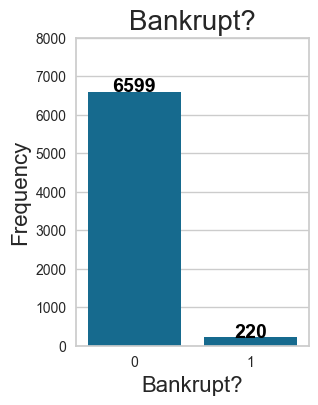

In [24]:
# Target variable
plt.figure(figsize=(3, 4)) 

ax = sns.countplot(x='Bankrupt?', data=dt)  # Rysowanie wykresu countplot

plt.title('Bankrupt?', fontsize=20)   # tytuł
plt.xlabel('Bankrupt?', fontsize=16)  # etykieta osi x
plt.ylabel('Frequency', fontsize=16)  # etykieta osi y
plt.ylim(0, 8000)

# Add frequency
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=14, color='black', fontweight='bold')

plt.show()

In [25]:
# Liability-Assets Flag
dt['Liability-Assets Flag'].value_counts()

Liability-Assets Flag
0    6811
1       8
Name: count, dtype: int64

In [26]:
# Net Income Flag
dt['Net Income Flag'].value_counts()
# remove

Net Income Flag
1    6819
Name: count, dtype: int64

In [27]:
dt.drop(columns=['Net Income Flag'], inplace=True)

#### Dataset

In [28]:
#dt.head()
dt.tail()

Bankrupt?  ROA(C) before interest and depreciation before interest  \
6814          0                                              0.494         
6815          0                                              0.475         
6816          0                                              0.473         
6817          0                                              0.506         
6818          0                                              0.493         

      ROA(A) before interest and % after tax  \
6814                                   0.539   
6815                                   0.538   
6816                                   0.534   
6817                                   0.560   
6818                                   0.570   

      ROA(B) before interest and depreciation after tax  \
6814                                              0.543   
6815                                              0.524   
6816                                              0.521   
6817                                              0.554   
6818                                              0.550   

      Operating Gross Margin  Realized Sales Gross Margin  \
6814                   0.604                        0.604   
6815                   0.598                        0.598   
6816                   0.610                        0.610   
6817                   0.608                        0.608   
6818                   0.627                        0.627   

      Operating Profit Rate  Pre-tax net Interest Rate  \
6814                  0.999                      0.797   
6815                  0.999                      0.797   
6816                  0.999                      0.797   
6817                  0.999                      0.797   
6818                  0.998                      0.802   

      After-tax net Interest Rate  \
6814                        0.809   
6815                        0.809   
6816                        0.809   
6817                        0.809   
6818                        0.814   

      Non-industry income and expenditure/revenue  ...  Liability-Assets Flag  \
6814                                        0.304  ...                      0   
6815                                        0.304  ...                      0   
6816                                        0.304  ...                      0   
6817                                        0.303  ...                      0   
6818                                        0.313  ...                      0   

      Net Income to Total Assets  Total assets to GNP price  \
6814                       0.800                      0.000   
6815                       0.800                      0.002   
6816                       0.798                      0.003   
6817                       0.812                      0.003   
6818                       0.816                      0.001   

      No-credit Interval  Gross Profit to Sales  \
6814               0.624                  0.604   
6815               0.624                  0.598   
6816               0.624                  0.610   
6817               0.624                  0.608   
6818               0.627                  0.627   

      Net Income to Stockholder's Equity  Liability to Equity  \
6814                               0.840                0.280   
6815                               0.840                0.278   
6816                               0.840                0.276   
6817                               0.841                0.278   
6818                               0.841                0.275   

      Degree of Financial Leverage (DFL)  \
6814                               0.027   
6815                               0.027   
6816                               0.027   
6817                               0.027   
6818                               0.027   

      Interest Coverage Ratio (Interest expense to EBIT)  Equity to Liability  
6814                                              0.566  

In [29]:
# Test & training split
dt['stratify_var'] = dt['Bankrupt?'].astype(str) + '_' + dt['Liability-Assets Flag'].astype(str)

X = dt.drop(['Bankrupt?', 'stratify_var'], axis=1)
y = dt['Bankrupt?']
stratify_var = dt['stratify_var']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=stratify_var, random_state=666)

In [30]:
X_train['Liability-Assets Flag'].value_counts()

Liability-Assets Flag
0    5448
1       7
Name: count, dtype: int64

In [31]:
X_test['Liability-Assets Flag'].value_counts()

Liability-Assets Flag
0    1363
1       1
Name: count, dtype: int64

In [32]:
y_test

3166    0
4287    0
2143    0
3429    0
4201    0
       ..
3139    0
6119    0
1083    0
3353    0
5871    0
Name: Bankrupt?, Length: 1364, dtype: int64

### c. Visual inspection of distributions

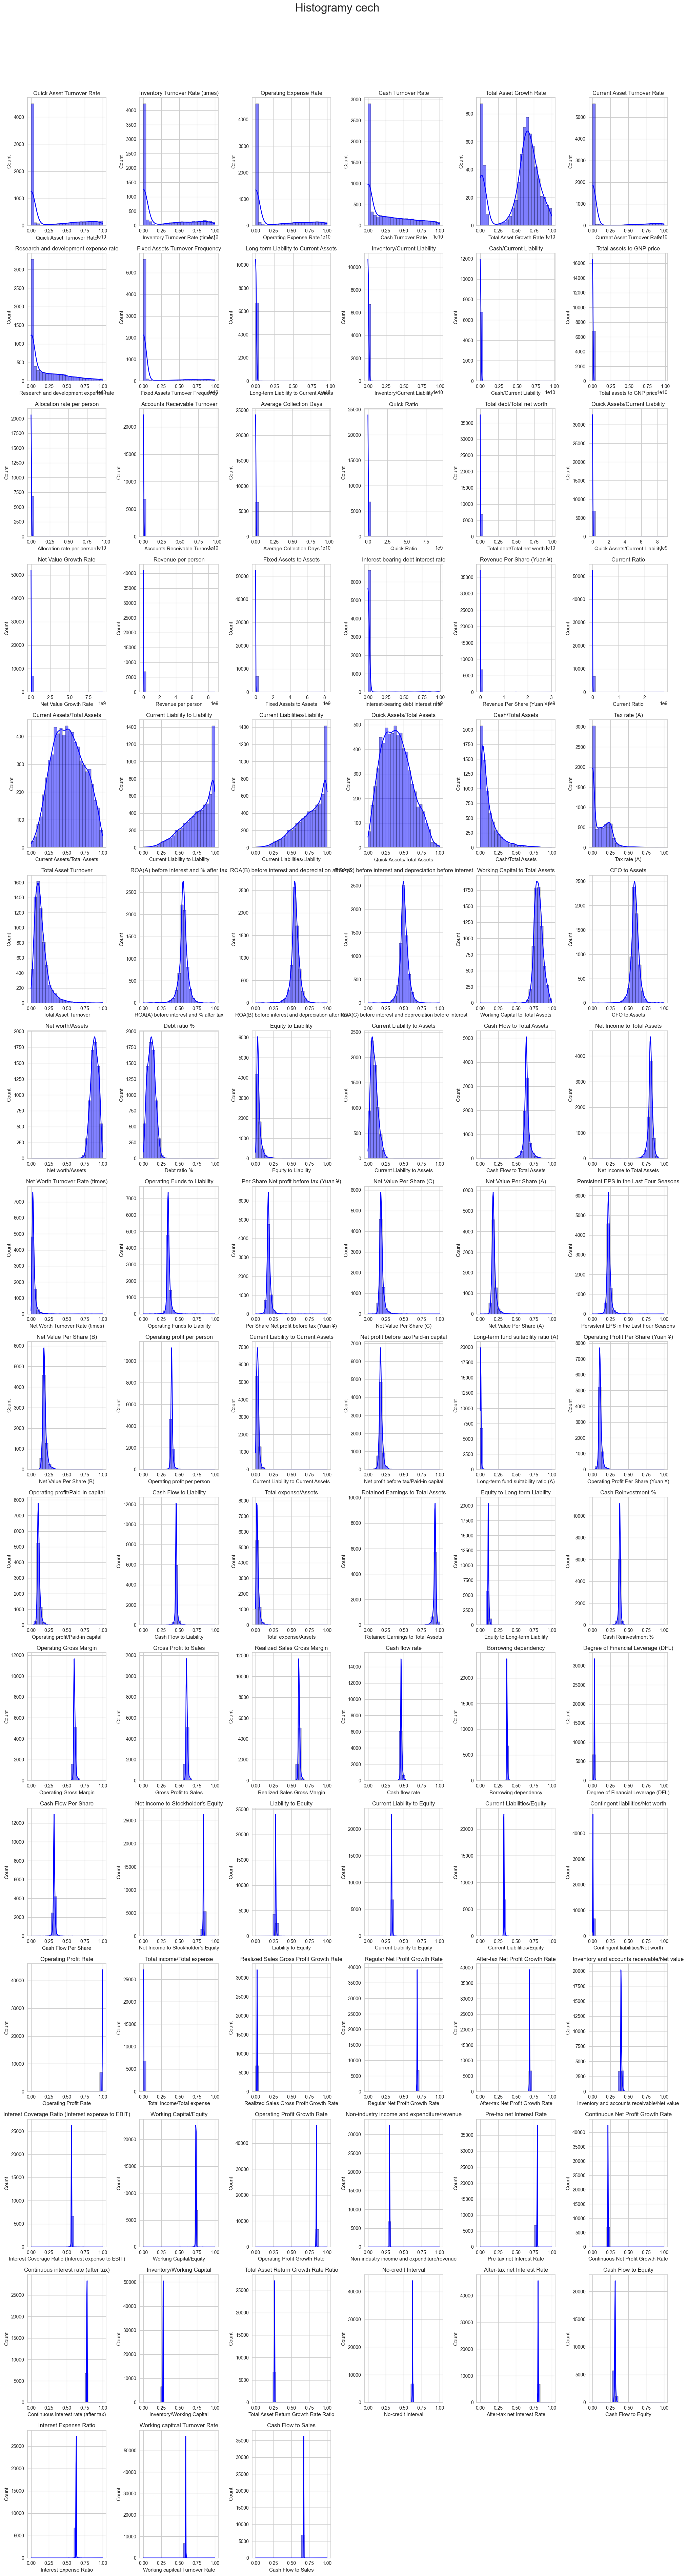

In [33]:
numeric_cols = X_train.select_dtypes(include=[np.number]).drop(columns=['Liability-Assets Flag'])

# variance of each variable
variances = numeric_cols.var()

# sort by variance
sorted_cols = variances.sort_values(ascending=False).index

# number of rows
num_cols = 6
num_rows = len(sorted_cols) // num_cols + (len(sorted_cols) % num_cols > 0)

# figure size
plt.figure(figsize=(20, num_rows * 5))

# plot histograms
for i, column in enumerate(sorted_cols, 1):
    plt.subplot(num_rows, num_cols, i)  # Tworzenie siatki wykresów
    sns.histplot(dt[column], bins=25, kde=True, color='blue')  # Tworzenie histogramu z krzywą KDE
    plt.title(column)  # Tytuł każdego wykresu

#
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Histogramy cech', fontsize=24)
plt.show()

#### violin plots

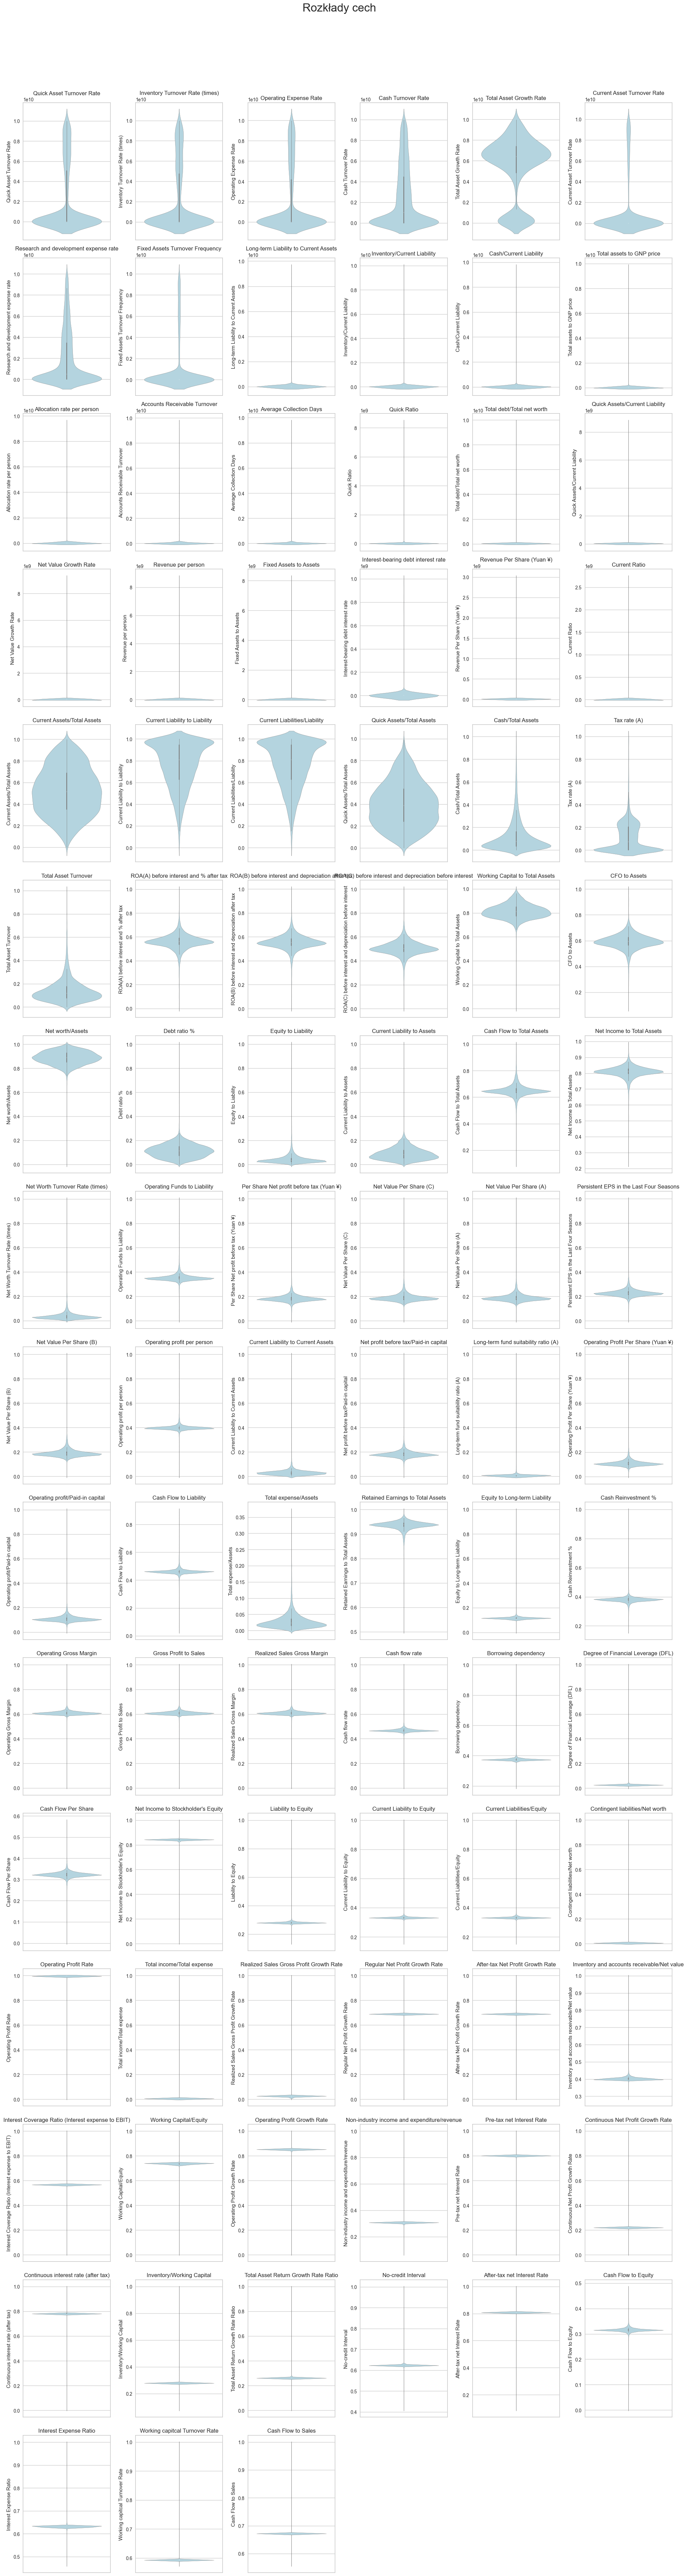

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, num_rows * 5))

for i, column in enumerate(sorted_cols, 1):
    plt.subplot(num_rows, num_cols, i)  # Tworzenie siatki wykresów
    sns.violinplot(y=X_train[column], color='lightblue')  # Wykres skrzypcowy
    plt.title(column)  # Tytuł każdego wykresu

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Rozkłady cech', fontsize=24)
plt.show()

In [35]:
X_train.shape

(5455, 94)

In [36]:
X_train

ROA(C) before interest and depreciation before interest  \
5844                                              0.516         
1859                                              0.548         
1794                                              0.564         
3632                                              0.473         
3405                                              0.571         
...                                                 ...         
4879                                              0.564         
2386                                              0.466         
3851                                              0.539         
4595                                              0.475         
6233                                              0.473         

      ROA(A) before interest and % after tax  \
5844                                   0.575   
1859                                   0.586   
1794                                   0.638   
3632                                   0.530   
3405                                   0.657   
...                                      ...   
4879                                   0.621   
2386                                   0.539   
3851                                   0.602   
4595                                   0.540   
6233                                   0.539   

      ROA(B) before interest and depreciation after tax  \
5844                                              0.568   
1859                                              0.588   
1794                                              0.624   
3632                                              0.526   
3405                                              0.640   
...                                                 ...   
4879                                              0.620   
2386                                              0.518   
3851                                              0.595   
4595                                              0.530   
6233                                              0.524   

      Operating Gross Margin  Realized Sales Gross Margin  \
5844                   0.610                        0.610   
1859                   0.612                        0.612   
1794                   0.617                        0.617   
3632                   0.603                        0.603   
3405                   0.628                        0.628   
...                      ...                          ...   
4879                   0.613                        0.613   
2386                   0.610                        0.610   
3851                   0.618                        0.618   
4595                   0.597                        0.597   
6233                   0.594                        0.595   

      Operating Profit Rate  Pre-tax net Interest Rate  \
5844                  0.999                      0.798   
1859                  0.999                      0.798   
1794                  0.999                      0.798   
3632                  0.999                      0.797   
3405                  0.999                      0.798   
...                     ...                        ...   
4879                  0.999                      0.798   
2386                  0.999                      0.797   
3851                  0.999                      0.798   
4595                  0.999                      0.797   
6233                  0.999                      0.797   

      After-tax net Interest Rate  \
5844                        0.809   
1859                        0.809   
1794                        0.809   
3632                        0.809   
3405                        0.810   
...                           ...   
4879                        0.810   
2386                        0.809   
3851                        0.809   
4595                        0.809   
6233                        0.809   

      Non-industry income and expenditure/revenue  \
5844       

In [37]:
features = [col for col in X_train.select_dtypes(include=[np.number]).columns if col != 'Bankrupt?']

In [38]:
# Yeo-Johnson transformer
pt = PowerTransformer(method='yeo-johnson')

# transform
X_train_transformed = pt.fit_transform(X_train[features])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=features)
X_train_transformed

ROA(C) before interest and depreciation before interest  \
0                                                 0.156         
1                                                 0.694         
2                                                 0.971         
3                                                -0.553         
4                                                 1.088         
...                                                 ...         
5450                                              0.963         
5451                                             -0.671         
5452                                              0.548         
5453                                             -0.524         
5454                                             -0.546         

      ROA(A) before interest and % after tax  \
0                                      0.210   
1                                      0.385   
2                                      1.263   
3                                     -0.488   
4                                      1.607   
...                                      ...   
5450                                   0.963   
5451                                  -0.365   
5452                                   0.653   
5453                                  -0.347   
5454                                  -0.352   

      ROA(B) before interest and depreciation after tax  \
0                                                 0.201   
1                                                 0.540   
2                                                 1.175   
3                                                -0.488   
4                                                 1.462   
...                                                 ...   
5450                                              1.091   
5451                                             -0.615   
5452                                              0.656   
5453                                             -0.429   
5454                                             -0.528   

      Operating Gross Margin  Realized Sales Gross Margin  \
0                      0.097                        0.098   
1                      0.230                        0.231   
2                      0.520                        0.522   
3                     -0.321                       -0.321   
4                      1.201                        1.198   
...                      ...                          ...   
5450                   0.275                        0.298   
5451                   0.086                        0.087   
5452                   0.584                        0.586   
5453                  -0.647                       -0.646   
5454                  -0.820                       -0.782   

      Operating Profit Rate  Pre-tax net Interest Rate  \
0                     0.095                      0.031   
1                     0.542                      0.040   
2                     0.307                      0.024   
3                    -0.063                     -0.004   
4                     0.806                      0.068   
...                     ...                        ...   
5450                  0.199                      0.059   
5451                 -0.061                      0.002   
5452                  0.332                      0.021   
5453                 -0.078                     -0.002   
5454                 -0.212                     -0.003   

      After-tax net Interest Rate  \
0                           0.029   
1                           0.034   
2                           0.026   
3                          -0.002   
4                           0.074   
...                           ...   
5450                        0.057   
5451                        0.004   
5452                        0.023   
5453                        0.001   
5454                       -0.000   

      Non-industry income and expenditure/revenue  \
0          

In [ ]:
# compare raw and transforemd variables
cols = 2
rows = 94

# fig size
plt.figure(figsize=(10, rows * 4))

for i, col in enumerate(numeric_cols.columns):
    # Oryginalne dane
    plt.subplot(rows, cols, 2*i + 1) 
    X_train[col].hist(bins=30)
    plt.title(f'Raw: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Yeo-Johnsona
    plt.subplot(rows, cols, 2*i + 2) 
    X_train_transformed[col].hist(bins=30, color='red') 
    plt.title(f'Yeo-Johnson: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [28]:
# Skośność i kurtoza zmiennych przed i po transformacji
# wybór zmiennych o akceptowalnej skośności i kurtozie lub takich, które poprawiły się co najmniej o 20%

# Oblicz skośność i kurtozę przed transformacją
skew_before = X_train[features].apply(lambda x: skew(x))
kurtosis_before = X_train[features].apply(lambda x: kurtosis(x))

# Zastosuj transformację Yeo-Johnsona
pt = PowerTransformer(method='yeo-johnson')
X_train_transformed = pd.DataFrame(pt.fit_transform(X_train[features]), columns=features)

# Oblicz skośność i kurtozę po transformacji
skew_after = X_train_transformed.apply(lambda x: skew(x))
kurtosis_after = X_train_transformed.apply(lambda x: kurtosis(x))

# Porównaj wyniki
improvement = pd.DataFrame({
    'Skew Before': skew_before,
    'Skew After': skew_after,
    'Kurtosis Before': kurtosis_before,
    'Kurtosis After': kurtosis_after
})

# Dodaj kolumny pokazujące różnicę
improvement['Skew Improvement'] = abs(improvement['Skew Before']) - abs(improvement['Skew After'])
improvement['Kurtosis Improvement'] = abs(improvement['Kurtosis Before']) - abs(improvement['Kurtosis After'])

# Ustal kryteria
acceptable_skewness = 1
acceptable_kurtosis = 1
threshold = 20

# Oblicz procentową poprawę
improvement['Skew Percent Improvement'] = (abs(improvement['Skew Before']) - abs(improvement['Skew After'])) / abs(improvement['Skew Before']) * 100
improvement['Kurtosis Percent Improvement'] = (abs(improvement['Kurtosis Before']) - abs(improvement['Kurtosis After'])) / abs(improvement['Kurtosis Before']) * 100

# Sprawdź, czy wartości po transformacji są akceptowalne
improvement['Skew Acceptable'] = abs(improvement['Skew After']) < acceptable_skewness
improvement['Kurtosis Acceptable'] = abs(improvement['Kurtosis After']) < acceptable_kurtosis

# Kombinacja kryteriów
improvement['Improved'] = (
    ((improvement['Skew Percent Improvement'] > threshold) & improvement['Skew Acceptable']) |
    ((improvement['Kurtosis Percent Improvement'] > threshold) & improvement['Kurtosis Acceptable'])
)

variables_to_transform = improvement[improvement['Improved']].index.tolist()
variables_not_to_transform = improvement[~improvement['Improved']].index.tolist()

In [29]:
print(variables_not_to_transform)

['Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Interest-bearing debt interest rate', 'Revenue Per Share (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-tax Net Profit Growth Rate', 'Regular Net Profit Growth Rate', 'Continuous Net Profit Growth Rate', 'Total Asset Growth Rate', 'Net Value Growth Rate', 'Total Asset Return Growth Rate Ratio', 'Quick Ratio', 'Interest Expense Ratio', 'Total debt/Total net worth', 'Long-term fund suitability ratio (A)', 'Borrowing dependency', 'Contingent liabilities/Net worth', 'Inventory and accounts receivable/Net value', 'Accounts Receivable Turnover', 'Average Collection Days', 'Operating profit per person', 'Allocation rate per person', 'Quick Assets/Current Liability', 'Cash/Current Liability', 'Inventory/Working Capital', 

In [30]:
print(variables_to_transform)

['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Cash Reinvestment %', 'Current Ratio', 'Debt ratio %', 'Net worth/Assets', 'Operating profit/Paid-in capital', 'Net profit before tax/Paid-in capital', 'Total Asset Turnover', 'Inventory Turnover Rate (times)', 'Fixed Assets Turnover Frequency', 'Net Worth Turnover Rate (times)', 'Revenue per person', 'Working Capital to Total Assets', 'Quick Assets/Total Assets', 'Current Assets/Total Assets', 'Cash/Total Assets', 'Current Liability to Assets', 'Operating Funds to Liability', 'Current Liabilities/Liability'

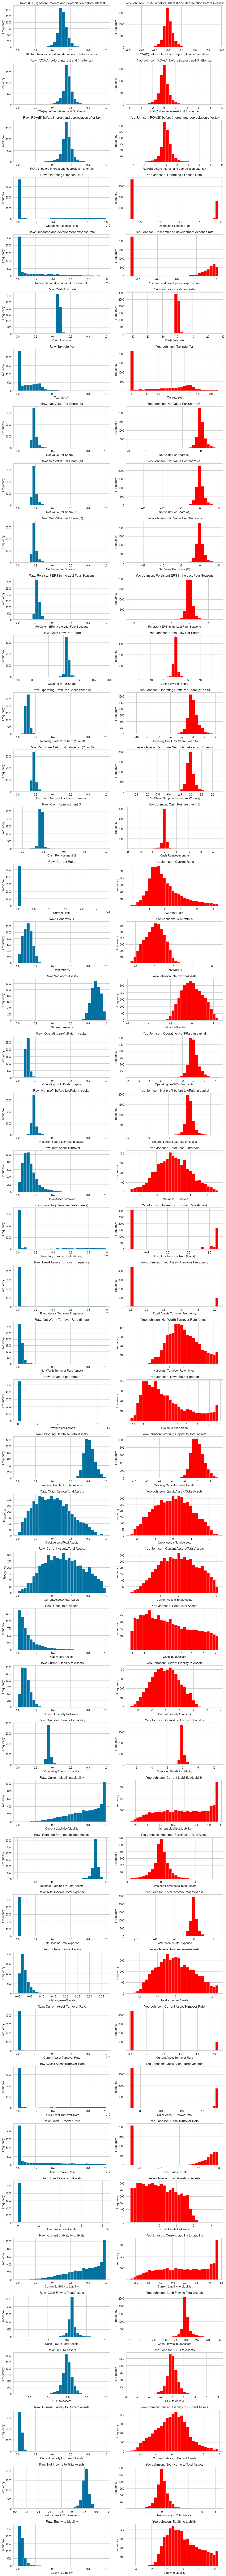

In [31]:
# Lista zmiennych do transformacji
variables = variables_to_transform
num_vars = len(variables)

# Ustawienie liczby kolumn (2 kolumny: oryginalne dane i dane po transformacji)
cols = 2

# Obliczenie liczby wierszy potrzebnych do wyświetlenia wszystkich zmiennych
rows = num_vars

# Ustawienie wielkości wykresów
plt.figure(figsize=(12, rows * 3))

# Iterowanie po zmiennych do transformacji
for i, col in enumerate(variables):
    # Oryginalne dane
    plt.subplot(rows, cols, 2 * i + 1)
    X_train[col].hist(bins=30)
    plt.title(f'Raw: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Dane po transformacji Yeo-Johnsona
    plt.subplot(rows, cols, 2 * i + 2)
    X_train_transformed[col].hist(bins=30, color='red')
    plt.title(f'Yeo-Johnson: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Wyświetlenie wszystkich histogramów
plt.tight_layout()
plt.show()

### d. Analiza korelacji

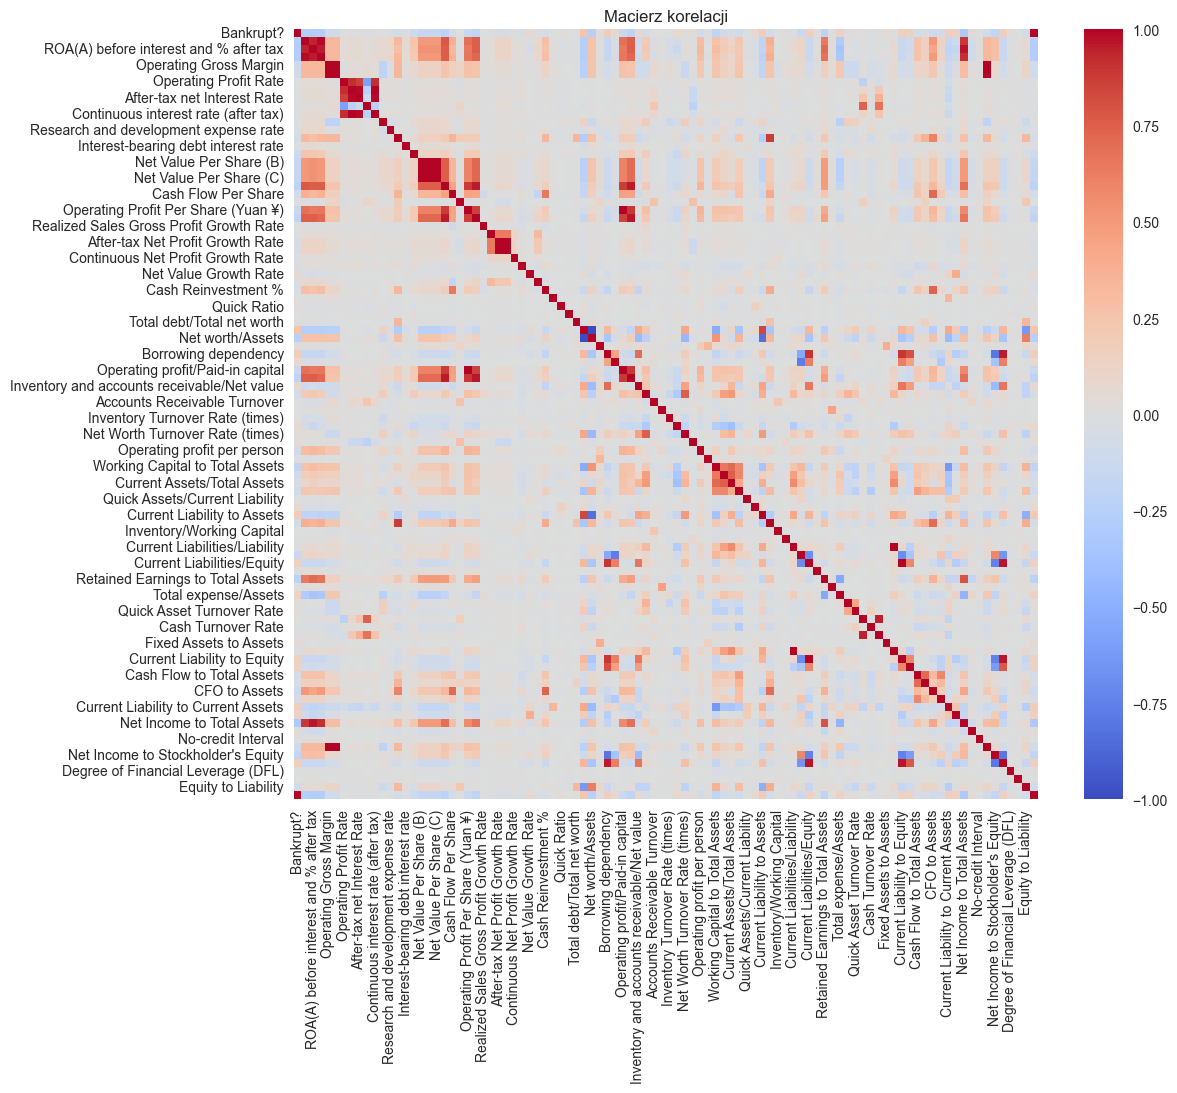

In [32]:
plt.figure(figsize=(12,10))
sns.heatmap(dt.corr(), cmap='coolwarm')
plt.title('Macierz korelacji')
plt.show()

In [33]:
variables_to_transform

['ROA(C) before interest and depreciation before interest',
 'ROA(A) before interest and % after tax',
 'ROA(B) before interest and depreciation after tax',
 'Operating Expense Rate',
 'Research and development expense rate',
 'Cash flow rate',
 'Tax rate (A)',
 'Net Value Per Share (B)',
 'Net Value Per Share (A)',
 'Net Value Per Share (C)',
 'Persistent EPS in the Last Four Seasons',
 'Cash Flow Per Share',
 'Operating Profit Per Share (Yuan ¥)',
 'Per Share Net profit before tax (Yuan ¥)',
 'Cash Reinvestment %',
 'Current Ratio',
 'Debt ratio %',
 'Net worth/Assets',
 'Operating profit/Paid-in capital',
 'Net profit before tax/Paid-in capital',
 'Total Asset Turnover',
 'Inventory Turnover Rate (times)',
 'Fixed Assets Turnover Frequency',
 'Net Worth Turnover Rate (times)',
 'Revenue per person',
 'Working Capital to Total Assets',
 'Quick Assets/Total Assets',
 'Current Assets/Total Assets',
 'Cash/Total Assets',
 'Current Liability to Assets',
 'Operating Funds to Liability',
 

# 2. Modelowanie Predykcyjne

#### Skalowanie danych

In [34]:
# Transformacja Yeo-Johnsona dla wybranych zmiennych
yeojohnson_transformer = ColumnTransformer(
    transformers=[
        ('yeojohnson', PowerTransformer(method='yeo-johnson'), variables_to_transform)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False  # Ustawienie na False, aby zachować oryginalne nazwy kolumn
)

# Pipeline: Transformacja Yeo-Johnsona, a następnie standaryzacja wszystkich zmiennych
full_pipeline = Pipeline(steps=[
    ('yeojohnson', yeojohnson_transformer),
    ('scaler', StandardScaler())
])

# Dopasowanie i transformacja danych treningowych
X_train_transformed = full_pipeline.fit_transform(X_train)

# Transformacja danych testowych
X_test_transformed = full_pipeline.transform(X_test)

# Ponieważ nazwy kolumn pozostają bez zmian, możemy użyć X_train.columns
feature_names = X_train.columns

# Stworzenie DataFrame z przetransformowanymi danymi
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names, index=X_test.index)

In [35]:
# Usuwam zmienne z najwyższym VIF
X_train_vif = X_train.copy()
y_train_vif = y_train.copy()

# Dodajemy stałą do X_train_vif
X_train_vif = sm.add_constant(X_train_vif)

def calculate_vif(X_train_vif, thresh=10.0):
    variables = list(X_train_vif.columns)
    variables.remove('const')  # Usuwamy 'const' z listy zmiennych do analizy
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_train_vif[variables].values, i)
               for i in range(len(variables))]

        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print(f"Usuwamy '{variables[maxloc]}' o VIF: {max_vif}")
            del variables[maxloc]
            dropped = True

    print("Pozostałe zmienne:")
    print(variables)
    return X_train_vif[['const'] + variables]  # Dodajemy 'const' z powrotem

# Wywołanie funkcji
X_reduced = calculate_vif(X_train_vif)

Usuwamy 'Net worth/Assets' o VIF: 163725583574.01736
Usuwamy 'Current Liabilities/Liability' o VIF: 3676407859077.956
Usuwamy 'Operating Profit Rate' o VIF: 607527266608.7274
Usuwamy 'Operating Gross Margin' o VIF: 75031231817.31163
Usuwamy 'Current Liability to Equity' o VIF: 3171435129.7034373
Usuwamy 'Current Assets/Total Assets' o VIF: 36414.234628730184
Usuwamy 'Net Income to Stockholder's Equity' o VIF: 28591.68138057351
Usuwamy 'After-tax net Interest Rate' o VIF: 29672516.078563705
Usuwamy 'Liability to Equity' o VIF: 141698.6472101286
Usuwamy 'Net Value Per Share (A)' o VIF: 129947.82572827081
Usuwamy 'Cash Flow to Equity' o VIF: 6293.103657269177
Usuwamy 'Cash flow rate' o VIF: 5446.5912990384095
Usuwamy 'Interest Coverage Ratio (Interest expense to EBIT)' o VIF: 1960.1273432765047
Usuwamy 'Realized Sales Gross Margin' o VIF: 1283707.8531339066
Usuwamy 'Working Capital/Equity' o VIF: 157046.2079089177
Usuwamy 'Operating Profit Growth Rate' o VIF: 12907.67954757204
Usuwamy 'Gr

In [36]:
X_reduced.drop(columns=['const'],inplace=True)
selected_v = X_reduced.columns.tolist()

### wybór danych do 3 eksperymentów

In [37]:
#EXP1 # dane bez transformacji
train_data = X_train.copy()
train_data['Bankrupt?'] = y_train

test_data = X_test.copy()
test_data['Bankrupt?'] = y_test

In [38]:
#EXP 2 # dane transformowane
train_T_data = X_train_transformed.copy()
train_T_data['Bankrupt?'] = y_train

test_T_data = X_test_transformed.copy()
test_T_data['Bankrupt?'] = y_test

In [39]:
#EXP 3 #ograniczona liczba zmiennych
train_V_data = X_train.copy()
train_V_data = train_V_data[selected_v]
train_V_data['Bankrupt?'] = y_train

test_V_data = X_test.copy()
test_V_data = test_V_data[selected_v]
test_V_data['Bankrupt?'] = y_test

### b. Wybór modeli

In [40]:
models_to_compare = [
   'catboost',  # CatBoost Classifier (lub 'cat')
   'lr',       #Logistic Regression
#    'knn',     #K Neighbors Classifier
    'nb',      #Naive Bayes
    'dt',      #Decision Tree Classifier
    'svm',     #SVM - Linear Kernel
#    'rbfsvm',  #SVM - Radial Kernel
#    'gpc',     #Gaussian Process Classifier
#    'mlp',     #MLP Classifier
    'ridge',   #Ridge Classifier
    'rf',      #Random Forest Classifier
    'qda',     #Quadratic Discriminant Analysis
    'ada',     #Ada Boost Classifier
    'gbc',     #Gradient Boosting Classifier
    'lda',     #Linear Discriminant Analysis
    'et',      #Extra Trees Classifier
    'xgboost', #Extreme Gradient Boosting
    'lightgbm',#Light Gradient Boosting Machine
#    'dummy'    #Dummy Classifier
]


In [41]:
# Mam do czynienia z niezbilansowanym zbiorem danych, metryką celu będzie F2 z parametrem beta = 2, co w praktyce oznacza położenie 4 krotnie wuększego nacisku na Recall
# Definicja funkcji f2_score
def f2_score(y_true, y_pred, **kwargs):
    return fbeta_score(y_true, y_pred, beta=2, **kwargs)
    
# Eksperyment 1
exp_clf1 = ClassificationExperiment()
exp_clf1.setup(
    data=train_data,
    target='Bankrupt?',
    test_data=test_data,
    session_id=666,
    use_gpu=True,
    fix_imbalance=True,
    fix_imbalance_method='adasyn',
    normalize=False,
    data_split_shuffle=False,
    fold=8,
    html=True
)

exp_clf1.add_metric(
    id='F2',
    name='F2 Score',
    score_func=f2_score,
    greater_is_better=True,
    optimize_for='binary',
    display_name='F2 Score'
)

best_model1 = exp_clf1.compare_models(include=models_to_compare, sort='F2 Score')

# Eksperyment 2
exp_clf2 = ClassificationExperiment()
exp_clf2.setup(
    data=train_T_data,
    target='Bankrupt?',
    test_data=test_T_data,
    session_id=666,
    use_gpu=True,
    fix_imbalance=True,
    fix_imbalance_method='adasyn',
    normalize=False,
    data_split_shuffle=False,
    fold=8,
    html=True
)

exp_clf2.add_metric(
    id='F2',
    name='F2 Score',
    score_func=f2_score,
    greater_is_better=True,
    optimize_for='binary',
    display_name='F2 Score'
)

best_model2 = exp_clf2.compare_models(include=models_to_compare, sort='F2 Score')


# Eksperyment 3
exp_clf3 = ClassificationExperiment()
exp_clf3.setup(
    data=train_V_data,
    target='Bankrupt?',
    test_data=test_V_data,
    session_id=666,
    use_gpu=True,
    fix_imbalance=True,
    fix_imbalance_method='adasyn',
    normalize=False,
    data_split_shuffle=False,
    fold=8,
    html=True
)

exp_clf3.add_metric(
    id='F2',
    name='F2 Score',
    score_func=f2_score,
    greater_is_better=True,
    optimize_for='binary',
    display_name='F2 Score'
)

best_model3 = exp_clf3.compare_models(include=models_to_compare, sort='F2 Score')

# Pobranie i wyświetlenie wyników
results1 = exp_clf1.pull()
results2 = exp_clf2.pull()
results3 = exp_clf3.pull()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1


[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negativ

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1



Eksperyment 1 - F2 Score na zbiorze testowym: 0.4831932773109244


Eksperyment 2 - F2 Score na zbiorze testowym: 0.3825136612021858


Eksperyment 3 - F2 Score na zbiorze testowym: 0.5434782608695652


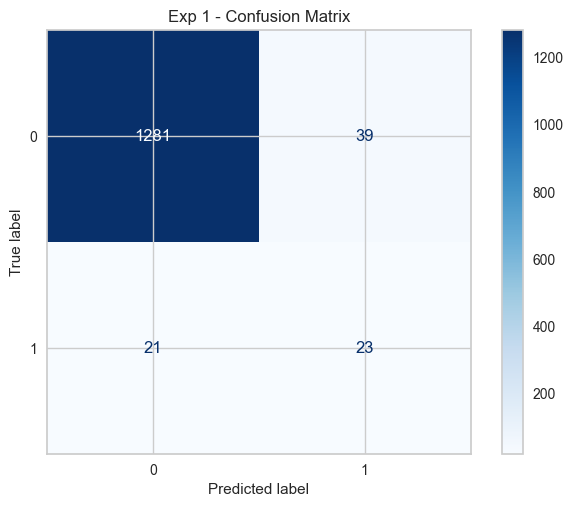

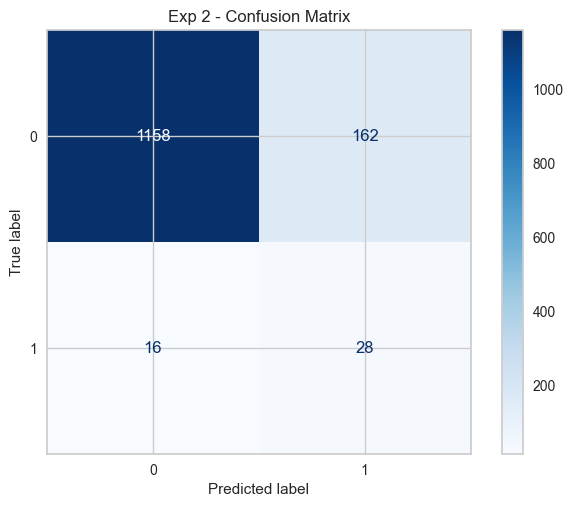

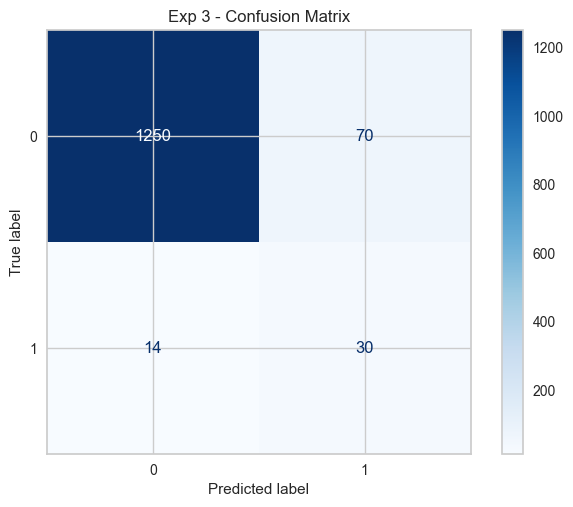

In [42]:
# Predykcje i ewaluacja na zbiorze testowym dla eksperymentu 1
predictions1 = exp_clf1.predict_model(best_model1)
y_true1 = test_data['Bankrupt?']
y_pred1 = predictions1['prediction_label']
f2_test1 = fbeta_score(y_true1, y_pred1, beta=2)
print("\nEksperyment 1 - F2 Score na zbiorze testowym:", f2_test1)

# Predykcje i ewaluacja na zbiorze testowym dla eksperymentu 2
predictions2 = exp_clf2.predict_model(best_model2)
y_true2 = test_T_data['Bankrupt?']
y_pred2 = predictions2['prediction_label']
f2_test2 = fbeta_score(y_true2, y_pred2, beta=2)
print("Eksperyment 2 - F2 Score na zbiorze testowym:", f2_test2)

# Predykcje i ewaluacja na zbiorze testowym dla eksperymentu 3
predictions3 = exp_clf3.predict_model(best_model3)
y_true3 = test_T_data['Bankrupt?']
y_pred3 = predictions3['prediction_label']
f2_test3 = fbeta_score(y_true3, y_pred3, beta=2)
print("Eksperyment 3 - F2 Score na zbiorze testowym:", f2_test3)

# Macierz konfuzji dla eksperymentu 1
cm1 = confusion_matrix(y_true1, y_pred1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap='Blues')
plt.title('Exp 1 - Confusion Matrix')
plt.show()

# Macierz konfuzji dla eksperymentu 2
cm2 = confusion_matrix(y_true2, y_pred2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(cmap='Blues')
plt.title('Exp 2 - Confusion Matrix')
plt.show()

# Macierz konfuzji dla eksperymentu 2
cm3 = confusion_matrix(y_true3, y_pred3)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp3.plot(cmap='Blues')
plt.title('Exp 3 - Confusion Matrix')
plt.show()

In [43]:
# Tuning hiperparametrów najlepszego modelu z eksperymentu 1
tuned_model1 = exp_clf1.tune_model(
    best_model1,
    optimize='F2 Score',  # Optymalizujemy pod kątem miary F2
    n_iter=100,           
    choose_better=True,   # Wybierz lepszy model między oryginalnym a stuningowanym
    verbose=True
)

Initiated  . . . . . . . . . . . . . . . . . .                   20:14:26
Status     . . . . . . . . . . . . . . . . . .  Searching Hyperparameters
Estimator  . . . . . . . . . . . . . . . . . .     Extra Trees Classifier

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 8 folds for each of 100 candidates, totalling 800 fits


KeyboardInterrupt: 

In [ ]:
# Tuning hiperparametrów najlepszego modelu z eksperymentu 2
tuned_model2 = exp_clf2.tune_model(
    best_model2,
    optimize='F2 Score',
    n_iter=100,
    choose_better=True,
    verbose=True
)

In [ ]:
# Tuning hiperparametrów najlepszego modelu z eksperymentu 2
tuned_model3 = exp_clf3.tune_model(
    best_model3,
    optimize='F2 Score',
    n_iter=100,
    choose_better=True,
    verbose=True
)

In [ ]:
# Dokonanie predykcji na zbiorze testowym
predictions_tuned1 = exp_clf1.predict_model(tuned_model1)

# Obliczenie miary F2 na zbiorze testowym
from sklearn.metrics import fbeta_score

y_true1 = test_data['Bankrupt?']
y_pred1_tuned = predictions_tuned1['prediction_label']

f2_test1_tuned = fbeta_score(y_true1, y_pred1_tuned, beta=2)
print("\nEksperyment 1 - F2 Score na zbiorze testowym po tuningu:", f2_test1_tuned)

In [ ]:
# Dokonanie predykcji na zbiorze testowym
predictions_tuned2 = exp_clf2.predict_model(tuned_model2)

# Obliczenie miary F2 na zbiorze testowym
y_true2 = test_T_data['Bankrupt?']
y_pred2_tuned = predictions_tuned2['prediction_label']

f2_test2_tuned = fbeta_score(y_true2, y_pred2_tuned, beta=2)
print("Eksperyment 2 - F2 Score na zbiorze testowym po tuningu:", f2_test2_tuned)

In [ ]:
# Dokonanie predykcji na zbiorze testowym
predictions_tuned3 = exp_clf3.predict_model(tuned_model3)

# Obliczenie miary F2 na zbiorze testowym
y_true3 = test_T_data['Bankrupt?']
y_pred3_tuned = predictions_tuned3['prediction_label']

f2_test3_tuned = fbeta_score(y_true3, y_pred3_tuned, beta=2)
print("Eksperyment 3 - F2 Score na zbiorze testowym po tuningu:", f2_test3_tuned)

In [ ]:
print("\nEksperyment 1:")
print("F2 Score przed tuningiem:", f2_test1)
print("F2 Score po tuningu:", f2_test1_tuned)

In [ ]:
print("\nEksperyment 2:")
print("F2 Score przed tuningiem:", f2_test2)
print("F2 Score po tuningu:", f2_test2_tuned)

In [ ]:
print("\nEksperyment 3:")
print("F2 Score przed tuningiem:", f2_test3)
print("F2 Score po tuningu:", f2_test3_tuned)

In [ ]:
# Wykres AUC
exp_clf1.plot_model(tuned_model1, plot='auc')

# Wykres ważności cech
exp_clf1.plot_model(tuned_model1, plot='feature')

In [ ]:
# Wykres AUC
exp_clf2.plot_model(tuned_model2, plot='auc')

# Wykres ważności cech
exp_clf2.plot_model(tuned_model2, plot='feature')

In [ ]:
# Wykres AUC
exp_clf3.plot_model(tuned_model3, plot='auc')

In [ ]:
# Wykres ważności cech
exp_clf3.plot_model(tuned_model3, plot='feature')

### b. Analiza SHAP

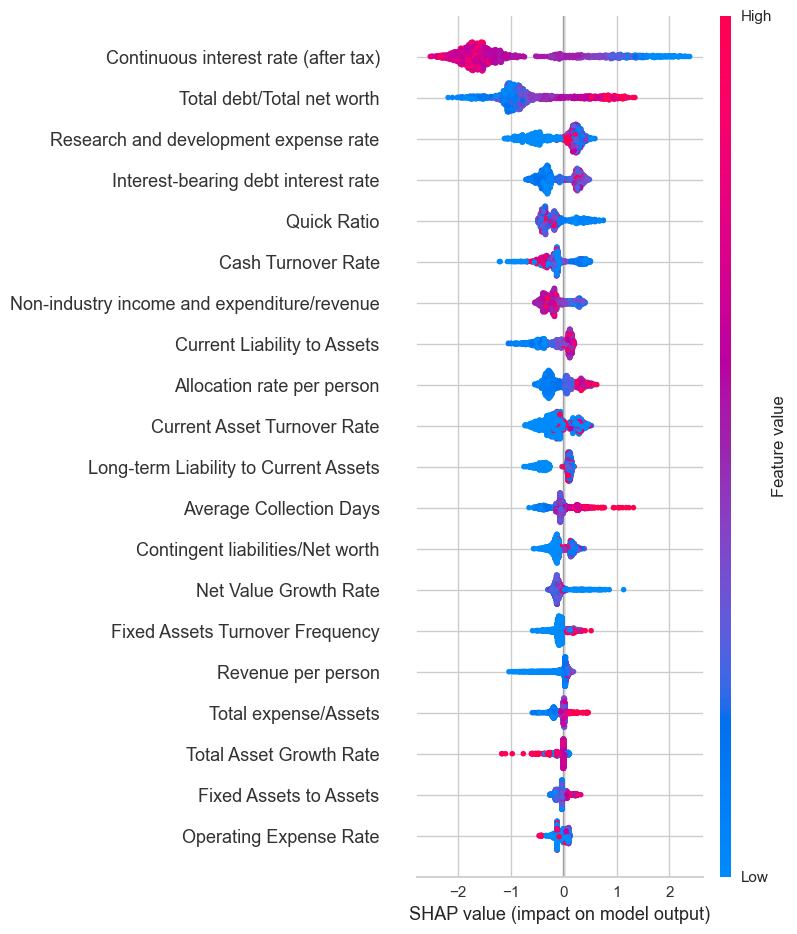

In [46]:
#import shap
#import matplotlib.pyplot as plt

# Stworzenie TreeExplainer dla modelu GradientBoostingClassifier
explainer = shap.TreeExplainer(best_model3)  # zakładam, że 'tuned_model3' to Twój wytrenowany model

# Obliczenie wartości SHAP dla przetworzonych danych testowych
shap_values = explainer.shap_values(test_V_data)

# Wygenerowanie wykresu beeswarm
# Przekazanie pełnej macierzy shap_values dla klasyfikacji binarnej (dla obu klas)
shap.summary_plot(shap_values, test_V_data)

In [ ]:
pip freeze > requirements.txt